### Import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 4)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import keras.backend as K

### Load the data into Pandas dataframe

In [ ]:
df = pd.read_csv(r'D:\REGI\0Teaching Materials\Data for Exercises\LoR - txt - SMSSpam detection_gd\SMSSpamCollection.csv',delimiter=',',encoding='latin-1')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,Class,sms
0,ham,Squeeeeeze!! This is christmas hug.. If u lik ...
1,ham,And also I've sorta blown him off a couple tim...
2,ham,Mmm thats better now i got a roast down me! iÂ...
3,ham,Mm have some kanji dont eat anything heavy ok
4,ham,So there's a ring that comes with the guys cos...


Drop the columns that are not required for the neural network.

In [ ]:
nltk_data_path = "D:/anaconda3/zstore"
import os
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.append(nltk_data_path)

In [ ]:
import nltk
nltk.download('stopwords', download_dir=nltk_data_path)
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to D:/anaconda3/zstore...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [ ]:
df['sms'] = df['sms'].replace(r'[^\w\s]|_', '', regex=True)
df['sms'] = df['sms'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
df['sms'] = df['sms'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df['sms'] = df['sms'].replace(r'[^\w\d]', ' ', regex=True)
df['sms'] = df['sms'].replace(r'ã¼', ' ', regex=True)
df['sms'] = df['sms'].replace(r'\b\w\b', ' ', regex=True)
df['sms'] = df['sms'].str.strip()
df['sms'] = df['sms'].str.replace(' +', ' ', regex=True)

In [ ]:
df.head()

,Class,sms
0,ham,squeeeeeze christmas hug lik frndshp den hug b...
1,ham,also ive sorta blown couple times recently id ...
2,ham,mmm thats better got roast iâd better drinks g...
3,ham,mm kanji dont eat anything heavy ok
4,ham,theres ring comes guys costumes gift future yo...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Understand the distribution better.

Text(0.5, 1.0, 'Number of ham and spam messages')

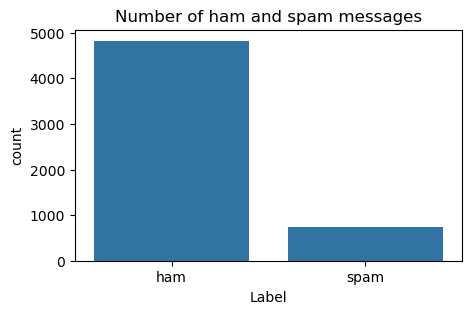

In [ ]:
plt.figure(figsize=(5,3))
sns.countplot(x=df.Class)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

* Create input and output vectors.
* Process the labels.

In [ ]:
X = df.sms
y = df.Class
le = LabelEncoder()
y = le.fit_transform(y)
y = y.reshape(-1,1)
print('y shape: ', y.shape)
print('y unique values: ', np.unique(y))

y shape:  (5572, 1)
y unique values:  [0 1]


Split into training and test data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify = y)

### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the *max_len* and here an arbitrary length of 150 is chosen.

In [ ]:
max_words = 1000
max_len = 150

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
train_seq = tok.texts_to_sequences(X_train)
train_seq_matrix = pad_sequences(train_seq, maxlen=max_len)

print('sequences[2] length: ', len(train_seq[2]))
print('sequences length: ', len(train_seq))
print(train_seq_matrix.shape)

sequences[2] length:  29
sequences length:  4736
(4736, 150)


In [ ]:
word_index = tok.word_index
print(dict(list(word_index.items())[:5]))

{'call': 1, 'im': 2, 'ur': 3, 'get': 4, 'ltgt': 5}


In [ ]:
len(word_index)

8705

In [ ]:
X_train

1614                                  awesome ill see bit
5186    shop till drop either 10k 5k â500 cash â100 tr...
677     boy loved gal propsd bt didnt mind gv lv lttrs...
2507                          always celebrate nys family
2344                                   ok come pick engin
                              ...                        
3844                                   time come tomorrow
2095                             aiyo please got time meh
5459                                    thought didnt see
4127                                     ltgt mca conform
5399    well obviously people cool college life went home
Name: sms, Length: 4736, dtype: object

In [ ]:
X_train[310]

'always chat fact need money raise'

In [ ]:
train_seq_matrix[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0, 505, 372, 471, 506, 507, 103, 392, 566,
         1, 965, 250, 227, 278, 228,  38])

In [ ]:
for ii in ('always chat fact need money raise').split():
    print(ii, word_index.get(ii))

always 142
chat 158
fact 769
need 22
money 126
raise 1628


### LSTM
Define the RNN structure.

In [ ]:
# Embedding (input_dim: size of vocabolary,
# output_dim: dimension of dense embedding,
# input_length: length of input sequence)

In [ ]:
K.clear_session()
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, name='out_layer', activation='sigmoid'))

In [ ]:
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          128000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                                 
Total params: 194,305
Trainable params: 194,305
Non-trainable params: 0
_________________________________________________________________


Fit on the training data.

In [ ]:
#es = EarlyStopping(monitor='val_loss', patience=4)
model.fit(train_seq_matrix, y_train, batch_size=128,epochs=10, validation_split=0.2, callbacks=[])

Epoch 1/10
30/30 [==============================] - 8s 172ms/step - loss: 0.4233 - accuracy: 0.8585 - val_loss: 0.2389 - val_accuracy: 0.8787
Epoch 2/10
30/30 [==============================] - 5s 154ms/step - loss: 0.1381 - accuracy: 0.9498 - val_loss: 0.0838 - val_accuracy: 0.9715
Epoch 3/10
30/30 [==============================] - 5s 174ms/step - loss: 0.0488 - accuracy: 0.9834 - val_loss: 0.0533 - val_accuracy: 0.9831
Epoch 4/10
30/30 [==============================] - 5s 154ms/step - loss: 0.0288 - accuracy: 0.9910 - val_loss: 0.0499 - val_accuracy: 0.9863
Epoch 5/10
30/30 [==============================] - 5s 153ms/step - loss: 0.0200 - accuracy: 0.9942 - val_loss: 0.0472 - val_accuracy: 0.9863
Epoch 6/10
30/30 [==============================] - 5s 154ms/step - loss: 0.0140 - accuracy: 0.9958 - val_loss: 0.0492 - val_accuracy: 0.9863
Epoch 7/10
30/30 [==============================] - 5s 152ms/step - loss: 0.0102 - accuracy: 0.9974 - val_loss: 0.0563 - val_accuracy: 0.9852
Epoch 

The model performs well on the validation set and this configuration is chosen as the final model.

Process the test set data.

In [ ]:
test_seq = tok.texts_to_sequences(X_test)
test_seq_matrix = pad_sequences(test_seq, maxlen=max_len)

Evaluate the model on the test set.

In [ ]:
accr = model.evaluate(test_seq_matrix,y_test)

27/27 [==============================] - 1s 22ms/step - loss: 0.1355 - accuracy: 0.9785


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.135
  Accuracy: 0.978


## GloVe

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('E:\Large\glove\glove.6B.50d.txt', encoding='cp437')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
vocab_size = len(tok.word_index) + 1
vocab_size

8706

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in tok.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
batch_size = 256
epochs = 20
embed_size = 50

In [ ]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=embed_size, weights=[embedding_matrix],
                    input_length=max_len, trainable=False))
#LSTM
model.add(LSTM(units=128 , return_sequences = True))
model.add(LSTM(units=64))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 50)           435300    
                                                                 
 lstm_1 (LSTM)               (None, 150, 128)          91648     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 578,469
Trainable params: 143,169
Non-trainable params: 435,300
_________________________________________________________________


In [ ]:
history = model.fit(train_seq_matrix, y_train, batch_size = batch_size, validation_split=0.1, epochs = epochs)

Epoch 1/20
17/17 [==============================] - 13s 549ms/step - loss: 0.4816 - accuracy: 0.8627 - val_loss: 0.2698 - val_accuracy: 0.9051
Epoch 2/20
17/17 [==============================] - 9s 560ms/step - loss: 0.2099 - accuracy: 0.9240 - val_loss: 0.1358 - val_accuracy: 0.9557
Epoch 3/20
17/17 [==============================] - 8s 478ms/step - loss: 0.1457 - accuracy: 0.9486 - val_loss: 0.1453 - val_accuracy: 0.9515
Epoch 4/20
17/17 [==============================] - 8s 459ms/step - loss: 0.1341 - accuracy: 0.9517 - val_loss: 0.1000 - val_accuracy: 0.9641
Epoch 5/20
11/17 [==================>...........] - ETA: 5s - loss: 0.1123 - accuracy: 0.9599 

In [ ]:
test_seq = tok.texts_to_sequences(X_test)
test_seq_matrix = pad_sequences(test_seq, maxlen=max_len)

Evaluate the model on the test set.

In [ ]:
accr = model.evaluate(test_seq_matrix, y_test)

27/27 [==============================] - 2s 74ms/step - loss: 0.0665 - accuracy: 0.9797


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.067
  Accuracy: 0.980


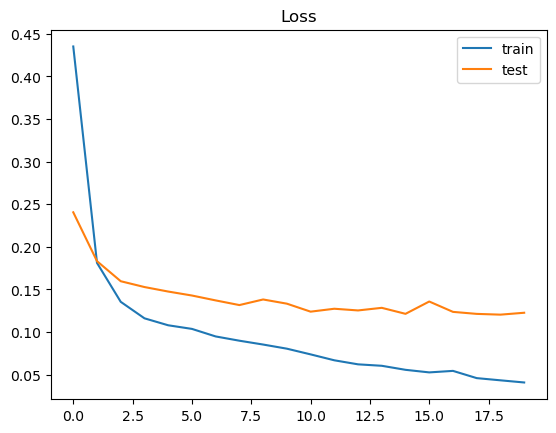

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

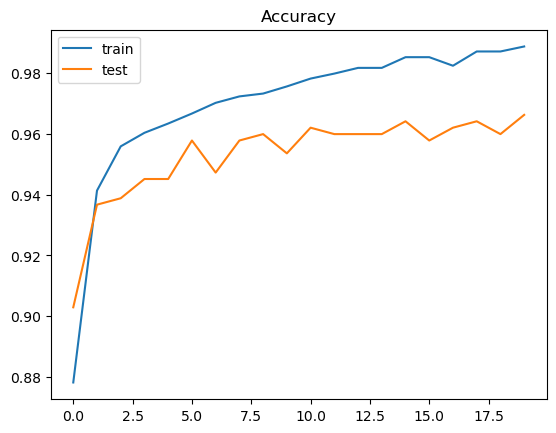

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

Test with a new complaint.

In [ ]:
new_complaint = ['Heavy discount, apply now .... immediately']
seq = tok.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['Spam', 'Ham']

print('\n')
print(pred, '\n', labels[np.argmax(pred)])

1/1 [==============================] - 1s 1s/step


[[0.9993667]] 
 Credit reporting, credit repair services, or other personal consumer reports


27/27 [==============================] - 1s 53ms/step
[[722   2]
 [ 15  97]]


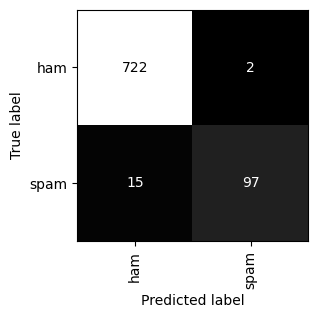

In [ ]:
y_test_prob = model.predict(test_seq_matrix)
y_test_pred = np.where(y_test_prob>0.5,1,0)
print(confusion_matrix(y_test, y_test_pred))

fig, ax = plt.subplots(figsize=(3,3))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=le.classes_,
            xticks_rotation="vertical", cmap='gray', ax=ax, colorbar=False)

### BiLSTM - Bidirectional LSTM

In [ ]:
from keras.layers import LSTM, Bidirectional

In [ ]:
K.clear_session()
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(256,name='FC1', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, name='out_layer', activation='sigmoid'))

In [ ]:
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          128000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 FC1 (Dense)                 (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                                 
Total params: 260,097
Trainable params: 260,097
Non-trainable params: 0
__________________________________________________

Fit on the training data.

In [ ]:
model.fit(train_seq_matrix, y_train, batch_size=128,epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

Epoch 1/10
30/30 [==============================] - 12s 281ms/step - loss: 0.4511 - accuracy: 0.8619 - val_loss: 0.3999 - val_accuracy: 0.8639
Epoch 2/10
30/30 [==============================] - 8s 252ms/step - loss: 0.3961 - accuracy: 0.8664 - val_loss: 0.4014 - val_accuracy: 0.8639
Epoch 3/10
30/30 [==============================] - 8s 257ms/step - loss: 0.3882 - accuracy: 0.8664 - val_loss: 0.4154 - val_accuracy: 0.8639
Epoch 4/10
30/30 [==============================] - 8s 254ms/step - loss: 0.3448 - accuracy: 0.8672 - val_loss: 0.4820 - val_accuracy: 0.8597
Epoch 5/10
30/30 [==============================] - 8s 255ms/step - loss: 0.3109 - accuracy: 0.8730 - val_loss: 0.5416 - val_accuracy: 0.8397


The model performs well on the validation set and this configuration is chosen as the final model.

Process the test set data.

In [ ]:
test_seq = tok.texts_to_sequences(X_test)
test_seq_matrix = pad_sequences(test_seq,maxlen=max_len)

Evaluate the model on the test set.

In [ ]:
accr = model.evaluate(test_seq_matrix,y_test)

27/27 [==============================] - 1s 41ms/step - loss: 0.6083 - accuracy: 0.8421


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.608
  Accuracy: 0.842
